# Tutorial: fitting a FSRQ broad-band SED using angpy and sherpa

In order to perform a fit of the broad-band SED of a jetted AGN, `agnpy` includes a `sherpa` wrapper.
The wrapper defines a custom [model.RegriddableModel1D](https://sherpa.readthedocs.io/en/latest/model_classes/api/sherpa.models.model.RegriddableModel1D.html), representing the emission due to a combination of radiative processes. The model can be used to fit flux points.

Several combination of radiative processes can be considered to model the broad-band emission of jetted AGN. For simplicity, we provide wrappers for the two scenarios most-commonly considered:

 * `SycnhrotronSelfComptonModel`, representing the sum of synchrotron and synchrotron self-Compton (SSC) radiation. This scenario is commonly considered to model BL Lac sources;

 * `ExternalComptonModel`, representing the sum of synchrotron and synchrotron self-Compton radiation along with an external Compton (EC) component. EC scattering can be computed considering a list of target photon fields. This scenario is commonly considered to model flat spectrum radio quasars (FSRQs).

In this tutorial, we will show how to use the `ExternalComptonModel` to fit the broad-band SED of PKS1510-089, measured during its gamma-ray flaring activity in 2015 [(Ahnen et al. 2017)](https://ui.adsabs.harvard.edu/abs/2017A%26A...603A..29A/abstract). We select the MWL SED corresponding to the period identified in the paper as "Period B" (MJD 57164-57166).

[sherpa](https://sherpa.readthedocs.io/en/latest/index.html) is required to run this notebook.

In [1]:
# import numpy, astropy and matplotlib for basic functionalities
import numpy as np
import astropy.units as u
from astropy.constants import c, G, M_sun
import matplotlib.pyplot as plt
import pkg_resources

# import agnpy classes
from agnpy.spectra import LogParabola
from agnpy.fit import ExternalComptonModel, load_sherpa_flux_points
from agnpy.utils.plot import load_mpl_rc, sed_y_label

load_mpl_rc()

# import sherpa classes
from sherpa.fit import Fit
from sherpa.stats import Chi2
from sherpa.optmethods import LevMar

### `sherpa` wrapper of `agnpy`


The `ExternalComptonModel` wraps the `agnpy` functions to compute synchrotron, SSC, and EC radiation. It returns a `model.RegriddableModel1D`. To initialise the model, the electron distribution and a list of targets for EC has to be specified, the remaining parameters (the ones of the emission region and of the line / thermal emitters) will be initialised automatically and can be modified at a later stage.

The `ExternalComptonModel` class provides both the `sherpa` and `gammapy` wrappers. You should specify, through the `backend` argument, which package you want to use.

In this case we choose to consider only EC on the DT radiation.

In [2]:
# electron energy distribution
n_e = LogParabola(
    k_e=1 * u.Unit("cm-3"), p=2.0, q=0.2, gamma_0=1e2, gamma_min=1, gamma_max=3e4
)

# initialise the sherpa model, consider only EC on the DT radiation
ec_model = ExternalComptonModel(n_e, ["dt"], ssa=True, backend="sherpa")

Let us set appropriate parameters for the emission region. The size of the blob, $R_{\rm b}$, is set by the variability timescale, $t_{\rm var}$, via

\begin{equation}
R_{\rm b} = \frac{c \delta_{\rm D} t_{\rm var}}{1 + z},
\end{equation}

where $c$ is the speed of light, $\delta_{\rm D}$ the Doppler factor, and $z$ the redshift.

The parameters of the accretion disk and the DT are taken from [(Ahnen et al. 2017)](https://ui.adsabs.harvard.edu/abs/2017A%26A...603A..29A/abstract).

In [3]:
z = 0.361

# - blob parameters
Gamma = 20
delta_D = 25
Beta = np.sqrt(1 - 1 / np.power(Gamma, 2))  # jet relativistic speed
mu_s = (1 - 1 / (Gamma * delta_D)) / Beta  # viewing angle
B = 0.35 * u.G
# size and location of the emission region
t_var = 0.5 * u.d
r = 6e17 * u.cm

# - disk parameters
L_disk = 6.7e45 * u.Unit("erg s-1")  # disk luminosity
M_BH = 5.71 * 1e7 * M_sun
eta = 1 / 12
m_dot = (L_disk / (eta * c ** 2)).to("g s-1")
R_g = ((G * M_BH) / c ** 2).to("cm")
R_in = 6 * R_g
R_out = 3e4 * R_g

# - DT parameters
xi_dt = 0.6
T_dt = 2e3 * u.K
# Ghisellini and Tavecchio's Formula
# relating the DT radius to the disk luminosity (check the reference)
R_dt = 2.5 * 1e18 * np.sqrt(L_disk.to_value("erg s-1") / 1e45) * u.cm

In [4]:
# emission regions parameters
ec_model.z = z
ec_model.delta_D = delta_D
ec_model.log10_B = np.log10(0.35)
ec_model.mu_s = mu_s
ec_model.t_var = t_var.to_value("s")
ec_model.t_var.freeze()
ec_model.log10_r = np.log10(r.to_value("cm"))

# we freeze the reference energy of the log parabola
ec_model.log10_gamma_0.freeze()

# target parameters
# - disk
ec_model.log10_L_disk = np.log10(L_disk.to_value("erg s-1"))
ec_model.M_BH = M_BH.to_value("g")
ec_model.m_dot = m_dot.to_value("g s-1")
ec_model.R_in = R_in.to_value("cm")
ec_model.R_out = R_out.to_value("cm")
# - DT
ec_model.xi_dt = xi_dt
ec_model.T_dt = T_dt.to_value("K")
ec_model.R_dt = R_dt.to_value("cm")

In [5]:
ec_model

<ExternalComptonRegriddableModel1D model instance 'ec'>

### Fitting with `sherpa`
Here we start the procedure to fit with `sherpa`.

#### 1) load the MWL flux points, add systematics
A function is provided in `agnpy.fit` to directly load flux points in a `sherpa.data.Data1D` object. It reads the data from a file, included in the package, containing a MWL SED following [these specifications](https://gamma-astro-data-formats.readthedocs.io/en/v0.2/spectra/flux_points/index.html).

The same function allows to add a systematic error on the flux points. This can be done with a dictionary specifying the instrument name and the systematic error, expressed as a relative error on the flux. The systematic error in summed in quadrature to the statistical error.

In this example, we use a very rough and conservative estimate of the systematic errors ($30\%$ of the flux for VHE instruments, $10\%$ for HE and X-ray instruments, $5\%$ for all the other instruments).

Specifying the systematic errors through the dictionary is optional.

We can also set the minimum and maximum energy to be used in the fit. We exclude points below $10^{11}\,{\rm Hz}$, as they are measured in the radio band with large integration regions. They hence include the extended emission of the jet, while in our model we are considering the emission from a finite region of the jet, the blob.

In [6]:
systematics_dict = {
    "Fermi-LAT": 0.10,
    "KVA1": 0.05,
    "KVA2": 0.05,
    "MAGIC": 0.30,
    "Metsahovi": 0.05,
    "NICS1": 0.05,
    "NICS2": 0.05,
    "SMART1": 0.05,
    "Swift-XRT": 0.10,
    "TCS1": 0.05,
    "TCS2": 0.05,
    "TCS3": 0.05,
    "TCS4": 0.05,
    "TCS5": 0.05,
    "TCS6": 0.05,
    "UVOT": 0.05,
}

# min and max energy to be considered in the fit
E_min = (1e11 * u.Hz).to("eV", equivalencies=u.spectral())
E_max = 100 * u.TeV

sed = load_sherpa_flux_points(
    "../../agnpy/data/mwl_seds/PKS1510-089_2015b.ecsv", E_min, E_max, systematics_dict
)

Let us take a look at the initial model and at the data.

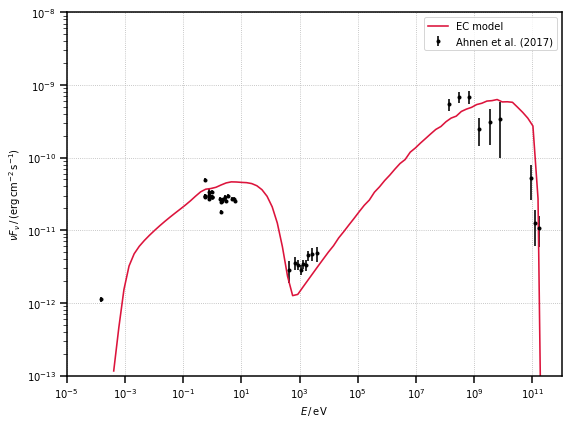

In [7]:
# array of energies to plot the model
E = np.logspace(np.log10(E_min.to_value("eV")), np.log10(E_max.to_value("eV")), 100)

fig, ax = plt.subplots(figsize=(8, 6))

ax.errorbar(
    sed.x,
    sed.y,
    yerr=sed.get_error(),
    marker=".",
    ls="",
    color="k",
    label="Ahnen et al. (2017)",
)
ax.loglog(E, ec_model(E), ls="-", color="crimson", label="EC model")
ax.set_ylabel(sed_y_label)
ax.set_xlabel(r"$E\,/\,{\rm eV}$")
ax.set_xlim([1e-5, 1e12])
ax.set_ylim([1e-13, 1e-8])
ax.legend()

plt.show()

#### 2) run the fit
Now we define the `Fit` procedure choosing the statistics ($\chi^2$) and the optimiser (Levenberg-Marquardt).

In [8]:
fitter = Fit(sed, ec_model, stat=Chi2(), method=LevMar())

In [9]:
%%time
# perform the fit and time it!
results = fitter.fit()
print("Fit succesful = ", results.succeeded)
print(results.format())

Fit succesful =  True
Method                = levmar
Statistic             = chi2
Initial fit statistic = 3396.08
Final fit statistic   = 220.712 at function evaluation 65
Data points           = 41
Degrees of freedom    = 36
Probability [Q-value] = 2.09563e-28
Reduced statistic     = 6.13088
Change in statistic   = 3175.37
   ec.log10_k_e   0.244905     +/- 0.277713    
   ec.p           2.1683       +/- 0.23791     
   ec.q           0.336091     +/- 0.0631399   
   ec.delta_D     25.8259      +/- 3.08421     
   ec.log10_B     -0.406479    +/- 0.0632429   
CPU times: user 11.7 s, sys: 3.62 s, total: 15.3 s
Wall time: 15.5 s


Plot the final model.

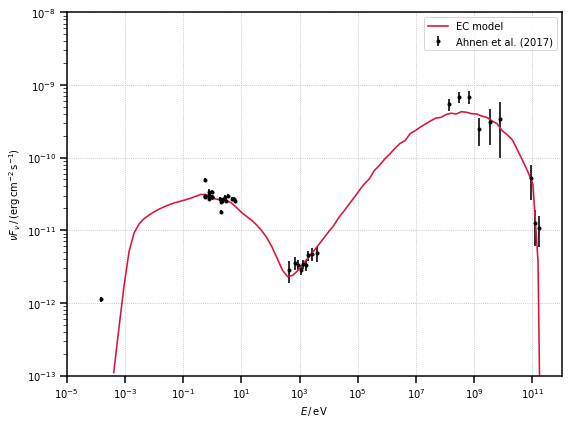

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.errorbar(
    sed.x,
    sed.y,
    yerr=sed.get_error(),
    marker=".",
    ls="",
    color="k",
    label="Ahnen et al. (2017)",
)
ax.loglog(E, ec_model(E), ls="-", color="crimson", label="EC model")
ax.set_ylabel(sed_y_label)
ax.set_xlabel(r"$E\,/\,{\rm eV}$")
ax.set_xlim([1e-5, 1e12])
ax.set_ylim([1e-13, 1e-8])
ax.legend()

plt.show()